# Обучение на основе 2D проекций

In [46]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Подготовка данных

In [48]:
datagen = N2V_DataGenerator()

N2V_DataGenerator создает патчи 
для обучения (<code>X</code>) и валидации модели (<code>X_val</code>)

In [51]:
imgs = datagen.load_imgs_from_directory(directory = "data_ML/V_beton_6_11.8um", dims="YX")
print(imgs[0].shape)

(1, 3241, 3236, 1)


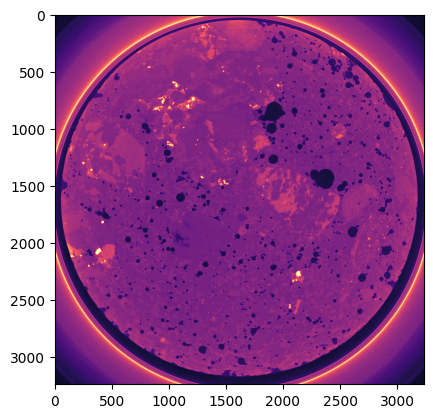

In [52]:
plt.imshow(imgs[0][0,...,0], cmap='magma')
plt.show()

In [53]:
# Разделение изображения на неперекрывающиеся патчи.
# y<2120 для обучения, y>=2120 для валидации.
imgs_train = [imgs[0][:,:2120]]
X = datagen.generate_patches_from_list(imgs_train,shape=(192,192))
imgs_vali = [imgs[0][:,2120:]]
X_val = datagen.generate_patches_from_list(imgs_vali,shape=(192,192))

Generated patches: (1408, 192, 192, 1)
Generated patches: (640, 192, 192, 1)


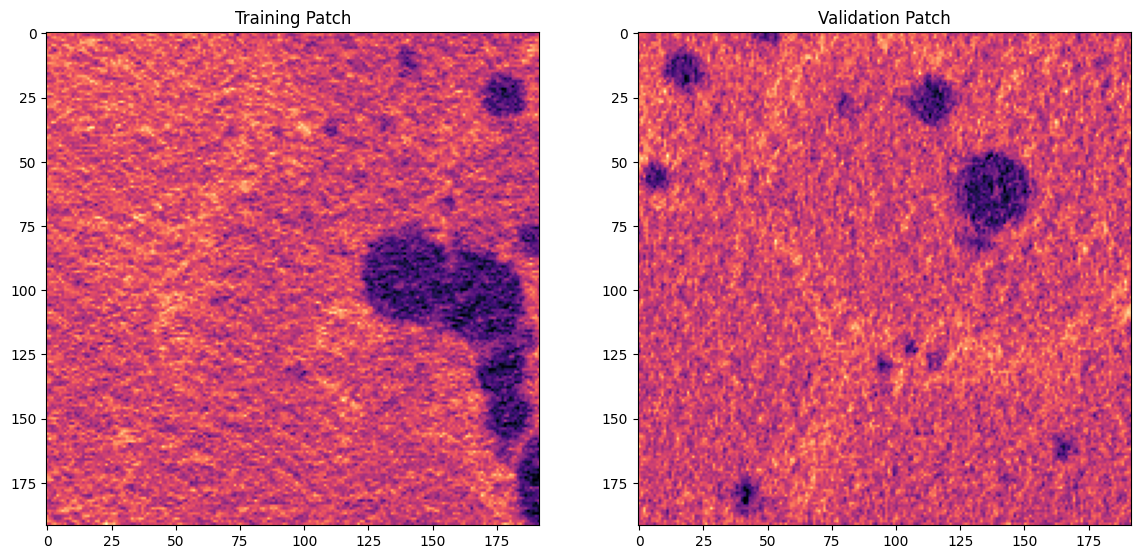

In [54]:
# Пример патчей.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');

# Настройка модели

In [55]:
config = N2VConfig(X, unet_residual=True, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128), train_epochs=100, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.33, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='normal_additive', n2v_neighborhood_radius=5, structN2Vmask=None, blurpool=True)

# Список параметров N2VConfig.
vars(config)

{'means': ['25455.775'],
 'stds': ['8724.649'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 100,
 'train_steps_per_epoch': 11,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.33,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'normal_additive',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': True,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [56]:
# Название директории с моделью
model_name = 'n2v_2D'
# Название директории для размещения модели
basedir = 'models'
# Создание модели
model = N2V(config, model_name, basedir=basedir)

# Обучение

In [57]:
history = model.train(X, X_val)

13 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|█████████████| 640/640 [00:00<00:00, 780.97it/s]


Epoch 1/100
11/11 [==============================] - 58s 5s/step - loss: 5.5437 - n2v_mse: 5.5437 - n2v_abs: 1.5788 - val_loss: 22.5764 - val_n2v_mse: 22.5764 - val_n2v_abs: 3.7997 - lr: 4.0000e-04
Epoch 2/100
11/11 [==============================] - 56s 5s/step - loss: 1.1372 - n2v_mse: 1.1372 - n2v_abs: 0.7737 - val_loss: 21.8563 - val_n2v_mse: 21.8563 - val_n2v_abs: 3.7368 - lr: 4.0000e-04
Epoch 3/100
11/11 [==============================] - 55s 5s/step - loss: 0.8438 - n2v_mse: 0.8438 - n2v_abs: 0.6793 - val_loss: 21.2491 - val_n2v_mse: 21.2491 - val_n2v_abs: 3.6838 - lr: 4.0000e-04
Epoch 4/100
11/11 [==============================] - 55s 5s/step - loss: 0.7472 - n2v_mse: 0.7472 - n2v_abs: 0.6365 - val_loss: 20.6435 - val_n2v_mse: 20.6435 - val_n2v_abs: 3.6328 - lr: 4.0000e-04
Epoch 5/100
11/11 [==============================] - 54s 5s/step - loss: 0.6313 - n2v_mse: 0.6313 - n2v_abs: 0.5983 - val_loss: 19.9330 - val_n2v_mse: 19.9330 - val_n2v_abs: 3.5732 - lr: 4.0000e-04
Epoch 6/10

### Анализ функций потерь при обучении и валидации

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


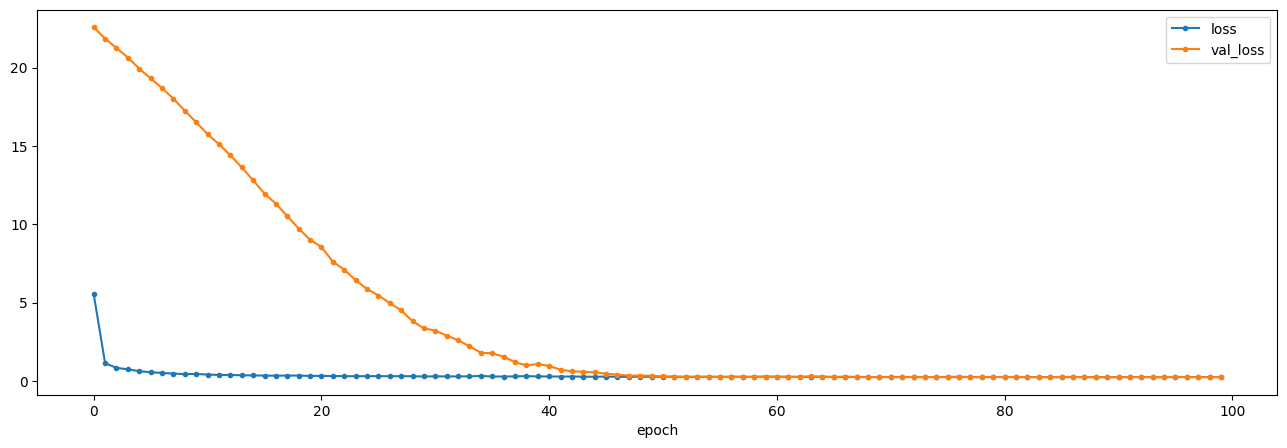

In [62]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);